# Reservoir Computing Project #

## Imports ##

In [1]:
import numpy as np
import matplotlib.pyplot as plt


## Lorenz ##

In [2]:
from reservoirpy.datasets import lorenz
X = lorenz(n_timesteps=2000)

print(X)

[[ 1.          1.          1.        ]
 [ 1.1073228   1.79872164  0.96516196]
 [ 1.40967473  2.74000007  0.97272208]
 ...
 [-0.27309074 -0.50415907  8.98103121]
 [-0.35422832 -0.66790582  8.29546755]
 [-0.46425047 -0.88919121  7.66653225]]


### Normal Lorenz 2D ###

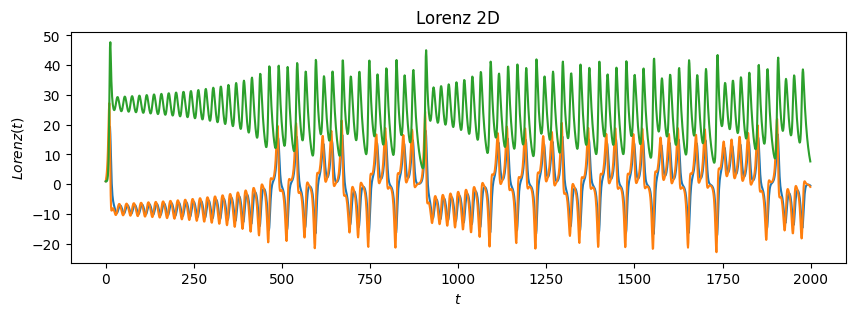

In [3]:
plt.figure(figsize=(10, 3))
plt.title("Lorenz 2D")
plt.ylabel("$Lorenz(t)$")
plt.xlabel("$t$")
plt.plot(X)
plt.show()

### 3D Lorenz ###

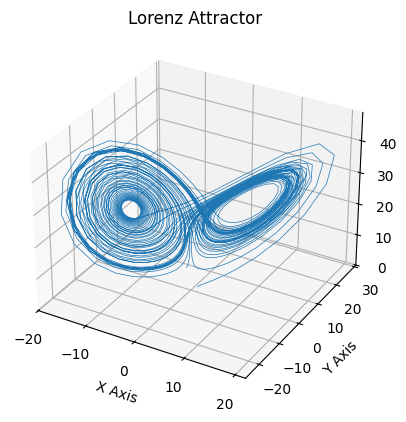

In [4]:
ax = plt.figure().add_subplot(projection='3d')

ax.plot(*X.T, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

In [5]:
from reservoirpy.nodes import Reservoir, Ridge

reservoir = Reservoir(units=100, lr=0.3, sr=1.25)
readout = Ridge(output_dim=3, ridge=1e-5)

### Train ESN ####

In [6]:
esn = reservoir >> readout

In [7]:
predictions = esn.fit(X[:500], X[1:501]).run(X[500:])

Running Model-0:   0%|          | 0/1 [00:00<?, ?it/s]

Running Model-0:   0%|          | 0/1 [00:00<?, ?it/s]

Running Model-0: 500it [00:00, 9200.82it/s]           


Running Model-0: 100%|██████████| 1/1 [00:00<00:00, 16.46it/s]

Fitting node Ridge-0...


Running Model-0:   0%|          | 0/1 [00:00<?, ?it/s]

Running Model-0: 435it [00:00, 4349.56it/s]           

Running Model-0: 870it [00:00, 4218.73it/s]

Running Model-0: 1293it [00:00, 4137.58it/s]

Running Model-0: 1500it [00:00, 4464.77it/s]

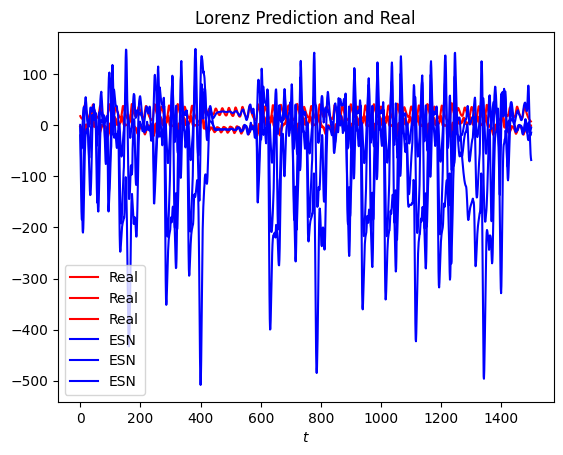

In [9]:
import numpy as np
import matplotlib.pyplot as plt
plt.title("Lorenz Prediction and Real")
plt.xlabel("$t$")
plt.plot(X[501:],label="Real",color="red")
plt.plot(predictions,label="ESN",color="blue")
plt.legend()
plt.show()

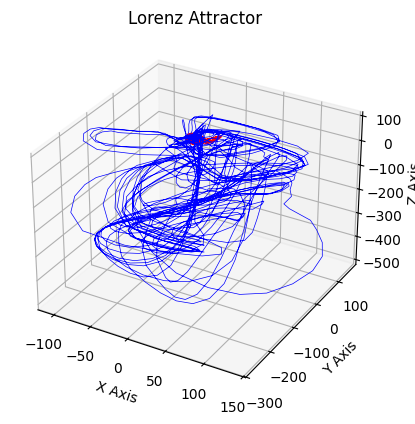

In [10]:
ax = plt.figure().add_subplot(projection='3d')

ax.plot(*X[501:].T,label="Real",color="red", lw=0.5)
ax.plot(*predictions.T,label="ESN",color="blue", lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

### Optimization ###

In [11]:
from reservoirpy.observables import nrmse, rsquare
# Objective functions accepted by ReservoirPy must respect some conventions:
#  - dataset and config arguments are mandatory, like the empty '*' expression.
#  - all parameters that will be used during the search must be placed after the *.
#  - the function must return a dict with at least a 'loss' key containing the result
# of the loss function. You can add any additional metrics or information with other
# keys in the dict. See hyperopt documentation for more informations.
def objective(dataset, config, *, input_scaling, N, sr, lr, ridge, seed):
    # This step may vary depending on what you put inside 'dataset'
    x_train, y_train, x_test, y_test = dataset

    # You can access anything you put in the config
    # file from the 'config' parameter.
    instances = config["instances_per_trial"]

    # The seed should be changed across the instances,
    # to be sure there is no bias in the results
    # due to initialization.
    variable_seed = seed

    losses = []; r2s = [];
    for n in range(instances):
        # Build your model given the input parameters
        reservoir = Reservoir(
            units=N,
            sr=sr,
            lr=lr,
            input_scaling=input_scaling,
            seed=variable_seed
        )

        readout = Ridge(ridge=ridge)

        model = reservoir >> readout


        # Train your model and test your model.
        predictions = model.fit(x_train, y_train) \
                           .run(x_test)

        loss = nrmse(y_test, predictions, norm_value=np.ptp(x_train))
        r2 = rsquare(y_test, predictions)

        # Change the seed between instances
        variable_seed += 1

        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when
    # using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}

In [12]:
import json

hyperopt_config = {
    "exp": "hyperopt-multiscroll",    # the experimentation name
    "hp_max_evals": 20,              # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",            # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                       # the random state seed, to ensure reproducibility
    "instances_per_trial": 5,         # how many random ESN will be tried with each sets of parameters
    "hp_space": {                     # what are the ranges of parameters explored
        "N": ["choice", 500],             # the number of neurons is fixed to 500
        "sr": ["loguniform", 1e-2, 10],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["loguniform", 1e-3, 1],    # idem with the leaking rate, from 1e-3 to 1
        "input_scaling": ["choice", 1.0], # the input scaling is fixed
        "ridge": ["loguniform", 1e-8, 1e1],        # and so is the regularization parameter.
        "seed": ["choice", 1234]          # an other random seed for the ESN initialization
    }
}

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

In [13]:
train_len = 1000
forecast = 2

X_train = X[:train_len]
Y_train = X[forecast : train_len + forecast]

X_test = X[train_len : -forecast]
Y_test = X[train_len + forecast:]

dataset = (X_train, Y_train, X_test, Y_test)

In [14]:
from reservoirpy.datasets import to_forecasting

X_train, X_test, Y_train, Y_test = to_forecasting(X, forecast=forecast, test_size=train_len-forecast)

In [15]:
from reservoirpy.hyper import research
best = research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

Running Model-1:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-1:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-1: 377it [00:00, 3765.21it/s]           


Running Model-1: 754it [00:00, 3510.21it/s]


Running Model-1: 1000it [00:00, 3257.27it/s]


Running Model-1: 100%|##########| 1/1 [00:00<00:00,  2.61it/s]


Running Model-1: 100%|##########| 1/1 [00:00<00:00,  2.61it/s]


Fitting node Ridge-1...
  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

Running Model-1:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-1: 305it [00:00, 3046.17it/s]           


Running Model-1: 635it [00:00, 3191.90it/s]


Running Model-1: 955it [00:00, 3140.95it/s]


Running Model-1: 998it [00:00, 2763.93it/s]


Running Model-2:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-2:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-2: 314it [00:00, 3138.81it/s]           


Running Model-2: 628it [00:00, 3132.27it/s]


Running Model-2: 943it [00:00, 3138.60it/s]


Running Model-2: 1000it [00:00, 3221.52it/s]


Running Model-2: 100%|##########| 1/1 [00:00<00:00,  3.09it/s]


Running Model-2: 100%|##########| 1/1 [00:00<00:00,  3.08it/s]


Fitting node Ridge-2...
  0%|          | 0/20 [00:01<?, ?trial/s, best loss=?]

Running Model-2:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-2: 294it [00:00, 2936.77it/s]           


Running Model-2: 588it [00:00, 2932.58it/s]


Running Model-2: 889it [00:00, 2967.31it/s]


Running Model-2: 998it [00:00, 2704.90it/s]


Running Model-3:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-3:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-3: 323it [00:00, 3226.03it/s]           


Running Model-3: 647it [00:00, 3234.17it/s]


Running Model-3: 974it [00:00, 3249.72it/s]


Running Model-3: 1000it [00:00, 3277.70it/s]


Running Model-3: 100%|##########| 1/1 [00:00<00:00,  3.15it/s]


Running Model-3: 100%|##########| 1/1 [00:00<00:00,  3.14it/s]


Fitting node Ridge-3...
  0%|          | 0/20 [00:02<?, ?trial/s, best loss=?]

Running Model-3:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-3: 314it [00:00, 3138.16it/s]           


Running Model-3: 646it [00:00, 3242.89it/s]


Running Model-3: 977it [00:00, 3272.37it/s]


Running Model-3: 998it [00:00, 3274.81it/s]


Running Model-4:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-4:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-4: 349it [00:00, 3489.36it/s]           


Running Model-4: 698it [00:00, 3442.51it/s]


Running Model-4: 1000it [00:00, 3332.72it/s]


Running Model-4: 100%|##########| 1/1 [00:00<00:00,  3.21it/s]


Running Model-4: 100%|##########| 1/1 [00:00<00:00,  3.20it/s]


Fitting node Ridge-4...
  0%|          | 0/20 [00:03<?, ?trial/s, best loss=?]

Running Model-4:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-4: 323it [00:00, 3228.45it/s]           


Running Model-4: 646it [00:00, 3227.60it/s]


Running Model-4: 998it [00:00, 3325.07it/s]


Running Model-5:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-5:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-5: 342it [00:00, 3417.91it/s]           


Running Model-5: 695it [00:00, 3480.98it/s]


Running Model-5: 1000it [00:00, 3404.09it/s]


Running Model-5: 100%|##########| 1/1 [00:00<00:00,  3.26it/s]


Running Model-5: 100%|##########| 1/1 [00:00<00:00,  2.79it/s]


Fitting node Ridge-5...
  0%|          | 0/20 [00:04<?, ?trial/s, best loss=?]

Running Model-5:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-5: 333it [00:00, 3328.38it/s]           


Running Model-5: 682it [00:00, 3422.26it/s]


Running Model-5: 998it [00:00, 3390.20it/s]


  5%|▌         | 1/20 [00:05<01:42,  5.40s/trial, best loss: 0.11030874811683782]

Running Model-6:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-6:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-6: 354it [00:00, 3535.73it/s]           


Running Model-6: 708it [00:00, 3475.72it/s]


Running Model-6: 1000it [00:00, 3358.45it/s]


Running Model-6: 100%|##########| 1/1 [00:00<00:00,  3.22it/s]


Running Model-6: 100%|##########| 1/1 [00:00<00:00,  3.21it/s]


Fitting node Ridge-6...
  5%|▌         | 1/20 [00:05<01:42,  5.40s/trial, best loss: 0.11030874811683782]

Running Model-6:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-6: 315it [00:00, 3146.16it/s]           


Running Model-6: 652it [00:00, 3277.41it/s]


Running Model-6: 980it [00:00, 3151.88it/s]


Running Model-6: 998it [00:00, 2727.72it/s]


Running Model-7:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-7:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-7: 310it [00:00, 3097.54it/s]           


Running Model-7: 649it [00:00, 3268.58it/s]


Running Model-7: 982it [00:00, 3294.73it/s]


Running Model-7: 1000it [00:00, 3287.01it/s]


Running Model-7: 100%|##########| 1/1 [00:00<00:00,  3.14it/s]


Running Model-7: 100%|##########| 1/1 [00:00<00:00,  3.13it/s]


Fitting node Ridge-7...
  5%|▌         | 1/20 [00:06<01:42,  5.40s/trial, best loss: 0.11030874811683782]

Running Model-7:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-7: 315it [00:00, 3148.76it/s]           


Running Model-7: 657it [00:00, 3306.06it/s]


Running Model-7: 997it [00:00, 3348.88it/s]


Running Model-7: 998it [00:00, 3311.23it/s]


Running Model-8:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-8:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-8: 354it [00:00, 3536.32it/s]           


Running Model-8: 708it [00:00, 3429.08it/s]


Running Model-8: 1000it [00:00, 3364.98it/s]


Running Model-8: 100%|##########| 1/1 [00:00<00:00,  3.22it/s]


Running Model-8: 100%|##########| 1/1 [00:00<00:00,  3.21it/s]


Fitting node Ridge-8...
  5%|▌         | 1/20 [00:07<01:42,  5.40s/trial, best loss: 0.11030874811683782]

Running Model-8:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-8: 343it [00:00, 3427.71it/s]           


Running Model-8: 686it [00:00, 3427.70it/s]


Running Model-8: 998it [00:00, 3345.17it/s]


Running Model-9:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-9:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-9: 365it [00:00, 3645.48it/s]           


Running Model-9: 730it [00:00, 3534.25it/s]


Running Model-9: 1000it [00:00, 3373.26it/s]


Running Model-9: 100%|##########| 1/1 [00:00<00:00,  3.23it/s]


Running Model-9: 100%|##########| 1/1 [00:00<00:00,  3.22it/s]


Fitting node Ridge-9...
  5%|▌         | 1/20 [00:08<01:42,  5.40s/trial, best loss: 0.11030874811683782]

Running Model-9:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-9: 334it [00:00, 3337.35it/s]           


Running Model-9: 696it [00:00, 3502.58it/s]


Running Model-9: 998it [00:00, 3396.23it/s]


Running Model-10:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-10:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-10: 348it [00:00, 2313.49it/s]           


Running Model-10: 687it [00:00, 2833.01it/s]


Running Model-10: 1000it [00:00, 3357.51it/s]


Running Model-10: 100%|##########| 1/1 [00:00<00:00,  2.75it/s]


Running Model-10: 100%|##########| 1/1 [00:00<00:00,  2.74it/s]


Fitting node Ridge-10...
  5%|▌         | 1/20 [00:09<01:42,  5.40s/trial, best loss: 0.11030874811683782]

Running Model-10:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-10: 338it [00:00, 3377.88it/s]           


Running Model-10: 686it [00:00, 3436.65it/s]


Running Model-10: 998it [00:00, 3384.40it/s]


 10%|█         | 2/20 [00:10<01:34,  5.28s/trial, best loss: 0.04983285370960316]

Running Model-11:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-11:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-11: 337it [00:00, 3368.08it/s]           


Running Model-11: 674it [00:00, 3363.12it/s]


Running Model-11: 1000it [00:00, 3337.17it/s]


Running Model-11: 100%|##########| 1/1 [00:00<00:00,  3.21it/s]


Running Model-11: 100%|##########| 1/1 [00:00<00:00,  3.20it/s]


Fitting node Ridge-11...
 10%|█         | 2/20 [00:11<01:34,  5.28s/trial, best loss: 0.04983285370960316]

Running Model-11:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-11: 343it [00:00, 3428.75it/s]           


Running Model-11: 693it [00:00, 3469.07it/s]


Running Model-11: 998it [00:00, 3386.30it/s]


Running Model-12:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-12:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-12: 356it [00:00, 3557.18it/s]           


Running Model-12: 712it [00:00, 3558.14it/s]


Running Model-12: 1000it [00:00, 3404.32it/s]


Running Model-12: 100%|##########| 1/1 [00:00<00:00,  3.24it/s]


Running Model-12: 100%|##########| 1/1 [00:00<00:00,  3.23it/s]


Fitting node Ridge-12...
 10%|█         | 2/20 [00:11<01:34,  5.28s/trial, best loss: 0.04983285370960316]

Running Model-12:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-12: 376it [00:00, 3757.99it/s]           


Running Model-12: 752it [00:00, 3701.63it/s]


Running Model-12: 998it [00:00, 4185.56it/s]


Running Model-13:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-13:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-13: 333it [00:00, 3327.81it/s]           


Running Model-13: 679it [00:00, 3402.90it/s]


Running Model-13: 1000it [00:00, 3278.05it/s]


Running Model-13: 100%|##########| 1/1 [00:00<00:00,  3.13it/s]


Running Model-13: 100%|##########| 1/1 [00:00<00:00,  2.67it/s]


Fitting node Ridge-13...
 10%|█         | 2/20 [00:13<01:34,  5.28s/trial, best loss: 0.04983285370960316]

Running Model-13:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-13: 315it [00:00, 3147.03it/s]           


Running Model-13: 645it [00:00, 3233.89it/s]


Running Model-13: 969it [00:00, 3232.47it/s]


Running Model-13: 998it [00:00, 3260.27it/s]


Running Model-14:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-14:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-14: 343it [00:00, 3429.51it/s]           


Running Model-14: 688it [00:00, 3440.17it/s]


Running Model-14: 1000it [00:00, 3337.84it/s]


Running Model-14: 100%|##########| 1/1 [00:00<00:00,  3.18it/s]


Running Model-14: 100%|##########| 1/1 [00:00<00:00,  3.17it/s]


Fitting node Ridge-14...
 10%|█         | 2/20 [00:14<01:34,  5.28s/trial, best loss: 0.04983285370960316]

Running Model-14:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-14: 315it [00:00, 3146.21it/s]           


Running Model-14: 666it [00:00, 3359.24it/s]


Running Model-14: 998it [00:00, 3341.19it/s]


Running Model-15:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-15:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-15: 316it [00:00, 3156.77it/s]           


Running Model-15: 633it [00:00, 3161.77it/s]


Running Model-15: 950it [00:00, 3153.59it/s]


Running Model-15: 1000it [00:00, 3218.53it/s]


Running Model-15: 100%|##########| 1/1 [00:00<00:00,  2.68it/s]


Running Model-15: 100%|##########| 1/1 [00:00<00:00,  2.67it/s]


Fitting node Ridge-15...
 10%|█         | 2/20 [00:15<01:34,  5.28s/trial, best loss: 0.04983285370960316]

Running Model-15:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-15: 356it [00:00, 3555.66it/s]           


Running Model-15: 712it [00:00, 3509.20it/s]


Running Model-15: 998it [00:00, 3388.18it/s]


 15%|█▌        | 3/20 [00:15<01:28,  5.19s/trial, best loss: 0.04983285370960316]

Running Model-16:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-16:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-16: 341it [00:00, 3409.38it/s]           


Running Model-16: 682it [00:00, 3362.60it/s]


Running Model-16: 1000it [00:00, 3304.12it/s]


Running Model-16: 100%|##########| 1/1 [00:00<00:00,  3.17it/s]


Running Model-16: 100%|##########| 1/1 [00:00<00:00,  3.16it/s]


Fitting node Ridge-16...
 15%|█▌        | 3/20 [00:16<01:28,  5.19s/trial, best loss: 0.04983285370960316]

Running Model-16:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-16: 323it [00:00, 3229.71it/s]           


Running Model-16: 661it [00:00, 3316.86it/s]


Running Model-16: 998it [00:00, 3335.78it/s]


Running Model-17:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-17:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-17: 362it [00:00, 3617.55it/s]           


Running Model-17: 724it [00:00, 3492.82it/s]


Running Model-17: 1000it [00:00, 3381.45it/s]


Running Model-17: 100%|##########| 1/1 [00:00<00:00,  3.23it/s]


Running Model-17: 100%|##########| 1/1 [00:00<00:00,  2.71it/s]


Fitting node Ridge-17...
 15%|█▌        | 3/20 [00:17<01:28,  5.19s/trial, best loss: 0.04983285370960316]

Running Model-17:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-17: 338it [00:00, 3376.21it/s]           


Running Model-17: 678it [00:00, 3389.86it/s]


Running Model-17: 998it [00:00, 3390.76it/s]


Running Model-18:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-18:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-18: 359it [00:00, 3587.75it/s]           


Running Model-18: 718it [00:00, 2591.45it/s]


Running Model-18: 1000it [00:00, 3242.65it/s]


Running Model-18: 100%|##########| 1/1 [00:00<00:00,  2.69it/s]


Running Model-18: 100%|##########| 1/1 [00:00<00:00,  2.68it/s]


Fitting node Ridge-18...
 15%|█▌        | 3/20 [00:18<01:28,  5.19s/trial, best loss: 0.04983285370960316]

Running Model-18:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-18: 329it [00:00, 3286.72it/s]           


Running Model-18: 678it [00:00, 3405.39it/s]


Running Model-18: 998it [00:00, 3361.36it/s]


Running Model-19:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-19:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-19: 349it [00:00, 3488.61it/s]           


Running Model-19: 698it [00:00, 3436.75it/s]


Running Model-19: 1000it [00:00, 3385.42it/s]


Running Model-19: 100%|##########| 1/1 [00:00<00:00,  3.24it/s]


Running Model-19: 100%|##########| 1/1 [00:00<00:00,  3.23it/s]


Fitting node Ridge-19...
 15%|█▌        | 3/20 [00:19<01:28,  5.19s/trial, best loss: 0.04983285370960316]

Running Model-19:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-19: 340it [00:00, 3395.75it/s]           


Running Model-19: 690it [00:00, 3455.03it/s]


Running Model-19: 998it [00:00, 3410.63it/s]


Running Model-20:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-20:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-20: 363it [00:00, 3628.82it/s]           


Running Model-20: 726it [00:00, 3256.48it/s]


Running Model-20: 1000it [00:00, 3231.85it/s]


Running Model-20: 100%|##########| 1/1 [00:00<00:00,  3.12it/s]


Running Model-20: 100%|##########| 1/1 [00:00<00:00,  3.11it/s]


Fitting node Ridge-20...
 15%|█▌        | 3/20 [00:20<01:28,  5.19s/trial, best loss: 0.04983285370960316]

Running Model-20:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-20: 356it [00:00, 3557.18it/s]           


Running Model-20: 723it [00:00, 3621.40it/s]


Running Model-20: 998it [00:00, 3364.57it/s]


 20%|██        | 4/20 [00:20<01:23,  5.19s/trial, best loss: 0.04983285370960316]

Running Model-21:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-21:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-21: 375it [00:00, 3746.91it/s]           


Running Model-21: 750it [00:00, 3700.83it/s]


Running Model-21: 1000it [00:00, 4193.55it/s]


Running Model-21: 100%|##########| 1/1 [00:00<00:00,  3.32it/s]


Running Model-21: 100%|##########| 1/1 [00:00<00:00,  3.31it/s]


Fitting node Ridge-21...
 20%|██        | 4/20 [00:21<01:23,  5.19s/trial, best loss: 0.04983285370960316]

Running Model-21:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-21: 317it [00:00, 3168.87it/s]           


Running Model-21: 679it [00:00, 3433.36it/s]


Running Model-21: 998it [00:00, 3372.66it/s]


Running Model-22:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-22:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-22: 367it [00:00, 3668.59it/s]           


Running Model-22: 734it [00:00, 3584.61it/s]


Running Model-22: 1000it [00:00, 3402.37it/s]


Running Model-22: 100%|##########| 1/1 [00:00<00:00,  3.28it/s]


Running Model-22: 100%|##########| 1/1 [00:00<00:00,  3.27it/s]


Fitting node Ridge-22...
 20%|██        | 4/20 [00:22<01:23,  5.19s/trial, best loss: 0.04983285370960316]

Running Model-22:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-22: 335it [00:00, 3349.60it/s]           


Running Model-22: 700it [00:00, 3526.00it/s]


Running Model-22: 998it [00:00, 3387.10it/s]


Running Model-23:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-23:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-23: 310it [00:00, 3096.44it/s]           


Running Model-23: 623it [00:00, 3115.95it/s]


Running Model-23: 946it [00:00, 3166.29it/s]


Running Model-23: 1000it [00:00, 3238.10it/s]


Running Model-23: 100%|##########| 1/1 [00:00<00:00,  2.62it/s]


Running Model-23: 100%|##########| 1/1 [00:00<00:00,  2.62it/s]


Fitting node Ridge-23...
 20%|██        | 4/20 [00:23<01:23,  5.19s/trial, best loss: 0.04983285370960316]

Running Model-23:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-23: 334it [00:00, 3339.55it/s]           


Running Model-23: 668it [00:00, 3291.61it/s]


Running Model-23: 998it [00:00, 3293.88it/s]


Running Model-23: 998it [00:00, 3287.13it/s]


Running Model-24:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-24:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-24: 338it [00:00, 3375.99it/s]           


Running Model-24: 676it [00:00, 3355.06it/s]


Running Model-24: 1000it [00:00, 3365.08it/s]


Running Model-24: 100%|##########| 1/1 [00:00<00:00,  3.25it/s]


Running Model-24: 100%|##########| 1/1 [00:00<00:00,  2.73it/s]


Fitting node Ridge-24...
 20%|██        | 4/20 [00:24<01:23,  5.19s/trial, best loss: 0.04983285370960316]

Running Model-24:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-24: 366it [00:00, 3655.75it/s]           


Running Model-24: 732it [00:00, 3571.94it/s]


Running Model-24: 998it [00:00, 4141.93it/s]


Running Model-25:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-25:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-25: 358it [00:00, 3577.57it/s]           


Running Model-25: 716it [00:00, 3568.91it/s]


Running Model-25: 1000it [00:00, 3432.78it/s]


Running Model-25: 100%|##########| 1/1 [00:00<00:00,  2.72it/s]


Running Model-25: 100%|##########| 1/1 [00:00<00:00,  2.71it/s]


Fitting node Ridge-25...
 20%|██        | 4/20 [00:25<01:23,  5.19s/trial, best loss: 0.04983285370960316]

Running Model-25:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-25: 322it [00:00, 3216.21it/s]           


Running Model-25: 683it [00:00, 3446.11it/s]


Running Model-25: 998it [00:00, 3364.75it/s]


 25%|██▌       | 5/20 [00:25<01:16,  5.13s/trial, best loss: 0.04983285370960316]

Running Model-26:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-26:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-26: 357it [00:00, 3565.84it/s]           


Running Model-26: 714it [00:00, 3495.87it/s]


Running Model-26: 1000it [00:00, 3379.35it/s]


Running Model-26: 100%|##########| 1/1 [00:00<00:00,  3.24it/s]


Running Model-26: 100%|##########| 1/1 [00:00<00:00,  3.23it/s]


Fitting node Ridge-26...
 25%|██▌       | 5/20 [00:26<01:16,  5.13s/trial, best loss: 0.04983285370960316]

Running Model-26:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-26: 348it [00:00, 3477.44it/s]           


Running Model-26: 729it [00:00, 3670.77it/s]


Running Model-26: 998it [00:00, 3435.46it/s]


Running Model-27:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-27:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-27: 371it [00:00, 3707.58it/s]           


Running Model-27: 742it [00:00, 3638.02it/s]


Running Model-27: 1000it [00:00, 3450.64it/s]


Running Model-27: 100%|##########| 1/1 [00:00<00:00,  3.31it/s]


Running Model-27: 100%|##########| 1/1 [00:00<00:00,  3.30it/s]


Fitting node Ridge-27...
 25%|██▌       | 5/20 [00:27<01:16,  5.13s/trial, best loss: 0.04983285370960316]

Running Model-27:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-27: 351it [00:00, 3509.81it/s]           


Running Model-27: 730it [00:00, 3671.79it/s]


Running Model-27: 998it [00:00, 3466.52it/s]


Running Model-28:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-28:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-28: 351it [00:00, 3505.49it/s]           


Running Model-28: 702it [00:00, 3462.95it/s]


Running Model-28: 1000it [00:00, 4062.02it/s]


Running Model-28: 100%|##########| 1/1 [00:00<00:00,  3.23it/s]


Running Model-28: 100%|##########| 1/1 [00:00<00:00,  3.22it/s]


Fitting node Ridge-28...
 25%|██▌       | 5/20 [00:28<01:16,  5.13s/trial, best loss: 0.04983285370960316]

Running Model-28:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-28: 383it [00:00, 3827.80it/s]           


Running Model-28: 766it [00:00, 3670.23it/s]


Running Model-28: 998it [00:00, 4157.92it/s]


Running Model-29:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-29:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-29: 349it [00:00, 3485.47it/s]           


Running Model-29: 712it [00:00, 3570.30it/s]


Running Model-29: 1000it [00:00, 3388.07it/s]


Running Model-29: 100%|##########| 1/1 [00:00<00:00,  3.25it/s]


Running Model-29: 100%|##########| 1/1 [00:00<00:00,  3.24it/s]


Fitting node Ridge-29...
 25%|██▌       | 5/20 [00:29<01:16,  5.13s/trial, best loss: 0.04983285370960316]

Running Model-29:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-29: 331it [00:00, 3306.26it/s]           


Running Model-29: 706it [00:00, 3565.82it/s]


Running Model-29: 998it [00:00, 3415.41it/s]


Running Model-30:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-30:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-30: 355it [00:00, 3548.25it/s]           


Running Model-30: 710it [00:00, 3489.71it/s]


Running Model-30: 1000it [00:00, 3409.00it/s]


Running Model-30: 100%|##########| 1/1 [00:00<00:00,  3.27it/s]


Running Model-30: 100%|##########| 1/1 [00:00<00:00,  3.26it/s]


Fitting node Ridge-30...
 25%|██▌       | 5/20 [00:30<01:16,  5.13s/trial, best loss: 0.04983285370960316]

Running Model-30:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-30: 354it [00:00, 3539.45it/s]           


Running Model-30: 715it [00:00, 3578.15it/s]


Running Model-30: 998it [00:00, 3420.90it/s]


 30%|███       | 6/20 [00:30<01:11,  5.09s/trial, best loss: 0.04983285370960316]

Running Model-31:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-31:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-31: 370it [00:00, 3698.75it/s]           


Running Model-31: 740it [00:00, 3644.35it/s]


Running Model-31: 1000it [00:00, 3416.36it/s]


Running Model-31: 100%|##########| 1/1 [00:00<00:00,  3.29it/s]


Running Model-31: 100%|##########| 1/1 [00:00<00:00,  3.28it/s]


Fitting node Ridge-31...
 30%|███       | 6/20 [00:31<01:11,  5.09s/trial, best loss: 0.04983285370960316]

Running Model-31:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-31: 340it [00:00, 3399.91it/s]           


Running Model-31: 702it [00:00, 3529.15it/s]


Running Model-31: 998it [00:00, 3444.56it/s]


Running Model-32:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-32:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-32: 357it [00:00, 3565.51it/s]           


Running Model-32: 714it [00:00, 3536.38it/s]


Running Model-32: 1000it [00:00, 3409.26it/s]


Running Model-32: 100%|##########| 1/1 [00:00<00:00,  3.26it/s]


Running Model-32: 100%|##########| 1/1 [00:00<00:00,  3.25it/s]


Fitting node Ridge-32...
 30%|███       | 6/20 [00:32<01:11,  5.09s/trial, best loss: 0.04983285370960316]

Running Model-32:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-32: 310it [00:00, 3096.19it/s]           


Running Model-32: 638it [00:00, 3203.29it/s]


Running Model-32: 959it [00:00, 3177.69it/s]


Running Model-32: 998it [00:00, 3231.59it/s]


Running Model-33:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-33:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-33: 365it [00:00, 3648.69it/s]           


Running Model-33: 730it [00:00, 3552.27it/s]


Running Model-33: 1000it [00:00, 3392.26it/s]


Running Model-33: 100%|##########| 1/1 [00:00<00:00,  2.70it/s]


Running Model-33: 100%|##########| 1/1 [00:00<00:00,  2.69it/s]


Fitting node Ridge-33...
 30%|███       | 6/20 [00:33<01:11,  5.09s/trial, best loss: 0.04983285370960316]

Running Model-33:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-33: 368it [00:00, 3674.67it/s]           


Running Model-33: 743it [00:00, 3717.82it/s]


Running Model-33: 998it [00:00, 3473.62it/s]


Running Model-34:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-34:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-34: 354it [00:00, 3539.79it/s]           


Running Model-34: 708it [00:00, 3484.21it/s]


Running Model-34: 1000it [00:00, 3329.06it/s]


Running Model-34: 100%|##########| 1/1 [00:00<00:00,  3.20it/s]


Running Model-34: 100%|##########| 1/1 [00:00<00:00,  3.19it/s]


Fitting node Ridge-34...
 30%|███       | 6/20 [00:34<01:11,  5.09s/trial, best loss: 0.04983285370960316]

Running Model-34:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-34: 323it [00:00, 3227.93it/s]           


Running Model-34: 690it [00:00, 3485.98it/s]


Running Model-34: 998it [00:00, 3400.97it/s]


Running Model-35:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-35:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-35: 372it [00:00, 3718.28it/s]           


Running Model-35: 744it [00:00, 3654.05it/s]


Running Model-35: 1000it [00:00, 3414.59it/s]


Running Model-35: 100%|##########| 1/1 [00:00<00:00,  3.28it/s]


Running Model-35: 100%|##########| 1/1 [00:00<00:00,  3.27it/s]


Fitting node Ridge-35...
 30%|███       | 6/20 [00:35<01:11,  5.09s/trial, best loss: 0.04983285370960316]

Running Model-35:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-35: 341it [00:00, 3406.64it/s]           


Running Model-35: 724it [00:00, 3653.51it/s]


Running Model-35: 998it [00:00, 3444.75it/s]


 35%|███▌      | 7/20 [00:35<01:05,  5.06s/trial, best loss: 0.04983285370960316]

Running Model-36:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-36:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-36: 347it [00:00, 3466.31it/s]           


Running Model-36: 707it [00:00, 3544.53it/s]


Running Model-36: 1000it [00:00, 3384.13it/s]


Running Model-36: 100%|##########| 1/1 [00:00<00:00,  3.24it/s]


Running Model-36: 100%|##########| 1/1 [00:00<00:00,  3.24it/s]


Fitting node Ridge-36...
 35%|███▌      | 7/20 [00:36<01:05,  5.06s/trial, best loss: 0.04983285370960316]

Running Model-36:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-36: 325it [00:00, 3246.25it/s]           


Running Model-36: 698it [00:00, 3529.89it/s]


Running Model-36: 998it [00:00, 3419.02it/s]


Running Model-37:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-37:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-37: 370it [00:00, 3699.80it/s]           


Running Model-37: 740it [00:00, 3694.91it/s]


Running Model-37: 1000it [00:00, 3439.71it/s]


Running Model-37: 100%|##########| 1/1 [00:00<00:00,  3.30it/s]


Running Model-37: 100%|##########| 1/1 [00:00<00:00,  3.29it/s]


Fitting node Ridge-37...
 35%|███▌      | 7/20 [00:37<01:05,  5.06s/trial, best loss: 0.04983285370960316]

Running Model-37:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-37: 332it [00:00, 3317.83it/s]           


Running Model-37: 666it [00:00, 3328.51it/s]


Running Model-37: 998it [00:00, 3334.88it/s]


Running Model-38:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-38:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-38: 349it [00:00, 3487.88it/s]           


Running Model-38: 698it [00:00, 3478.64it/s]


Running Model-38: 1000it [00:00, 3372.41it/s]


Running Model-38: 100%|##########| 1/1 [00:00<00:00,  3.23it/s]


Running Model-38: 100%|##########| 1/1 [00:00<00:00,  3.22it/s]


Fitting node Ridge-38...
 35%|███▌      | 7/20 [00:38<01:05,  5.06s/trial, best loss: 0.04983285370960316]

Running Model-38:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-38: 310it [00:00, 3098.53it/s]           


Running Model-38: 677it [00:00, 3434.40it/s]


Running Model-38: 998it [00:00, 3392.67it/s]


Running Model-39:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-39:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-39: 357it [00:00, 3566.48it/s]           


Running Model-39: 714it [00:00, 3532.96it/s]


Running Model-39: 1000it [00:00, 3415.01it/s]


Running Model-39: 100%|##########| 1/1 [00:00<00:00,  3.28it/s]


Running Model-39: 100%|##########| 1/1 [00:00<00:00,  3.27it/s]


Fitting node Ridge-39...
 35%|███▌      | 7/20 [00:39<01:05,  5.06s/trial, best loss: 0.04983285370960316]

Running Model-39:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-39: 335it [00:00, 3346.19it/s]           


Running Model-39: 670it [00:00, 3334.89it/s]


Running Model-39: 998it [00:00, 3357.90it/s]


Running Model-40:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-40:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-40: 340it [00:00, 3399.17it/s]           


Running Model-40: 710it [00:00, 3573.64it/s]


Running Model-40: 1000it [00:00, 3392.07it/s]


Running Model-40: 100%|##########| 1/1 [00:00<00:00,  3.25it/s]


Running Model-40: 100%|##########| 1/1 [00:00<00:00,  3.24it/s]


Fitting node Ridge-40...
 35%|███▌      | 7/20 [00:40<01:05,  5.06s/trial, best loss: 0.04983285370960316]

Running Model-40:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-40: 356it [00:00, 3558.20it/s]           


Running Model-40: 712it [00:00, 3500.00it/s]


Running Model-40: 998it [00:00, 4100.02it/s]


 40%|████      | 8/20 [00:40<01:00,  5.05s/trial, best loss: 0.04983285370960316]

Running Model-41:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-41:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-41: 328it [00:00, 3278.57it/s]           


Running Model-41: 672it [00:00, 3370.84it/s]


Running Model-41: 1000it [00:00, 3342.19it/s]


Running Model-41: 100%|##########| 1/1 [00:00<00:00,  3.21it/s]


Running Model-41: 100%|##########| 1/1 [00:00<00:00,  3.20it/s]


Fitting node Ridge-41...
 40%|████      | 8/20 [00:41<01:00,  5.05s/trial, best loss: 0.04983285370960316]

Running Model-41:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-41: 346it [00:00, 3456.31it/s]           


Running Model-41: 705it [00:00, 3532.61it/s]


Running Model-41: 998it [00:00, 3386.27it/s]


Running Model-42:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-42:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-42: 343it [00:00, 3429.26it/s]           


Running Model-42: 686it [00:00, 3398.85it/s]


Running Model-42: 1000it [00:00, 3374.40it/s]


Running Model-42: 100%|##########| 1/1 [00:00<00:00,  3.23it/s]


Running Model-42: 100%|##########| 1/1 [00:00<00:00,  3.22it/s]


Fitting node Ridge-42...
 40%|████      | 8/20 [00:42<01:00,  5.05s/trial, best loss: 0.04983285370960316]

Running Model-42:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-42: 340it [00:00, 3398.86it/s]           


Running Model-42: 707it [00:00, 3557.39it/s]


Running Model-42: 998it [00:00, 3417.89it/s]


Running Model-43:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-43:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-43: 361it [00:00, 3606.53it/s]           


Running Model-43: 722it [00:00, 3518.76it/s]


Running Model-43: 1000it [00:00, 3332.81it/s]


Running Model-43: 100%|##########| 1/1 [00:00<00:00,  3.21it/s]


Running Model-43: 100%|##########| 1/1 [00:00<00:00,  3.20it/s]


Fitting node Ridge-43...
 40%|████      | 8/20 [00:43<01:00,  5.05s/trial, best loss: 0.04983285370960316]

Running Model-43:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-43: 336it [00:00, 3359.70it/s]           


Running Model-43: 672it [00:00, 3329.22it/s]


Running Model-43: 998it [00:00, 3304.49it/s]


Running Model-44:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-44:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-44: 330it [00:00, 3296.50it/s]           


Running Model-44: 660it [00:00, 3251.11it/s]


Running Model-44: 986it [00:00, 3227.48it/s]


Running Model-44: 1000it [00:00, 3247.76it/s]


Running Model-44: 100%|##########| 1/1 [00:00<00:00,  3.13it/s]


Running Model-44: 100%|##########| 1/1 [00:00<00:00,  3.12it/s]


Fitting node Ridge-44...
 40%|████      | 8/20 [00:44<01:00,  5.05s/trial, best loss: 0.04983285370960316]

Running Model-44:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-44: 325it [00:00, 3249.50it/s]           


Running Model-44: 687it [00:00, 3466.22it/s]


Running Model-44: 998it [00:00, 3361.99it/s]


Running Model-45:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-45:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-45: 354it [00:00, 3536.74it/s]           


Running Model-45: 718it [00:00, 3595.17it/s]


Running Model-45: 1000it [00:00, 3445.40it/s]


Running Model-45: 100%|##########| 1/1 [00:00<00:00,  3.31it/s]


Running Model-45: 100%|##########| 1/1 [00:00<00:00,  3.31it/s]


Fitting node Ridge-45...
 40%|████      | 8/20 [00:45<01:00,  5.05s/trial, best loss: 0.04983285370960316]

Running Model-45:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-45: 304it [00:00, 3038.06it/s]           


Running Model-45: 650it [00:00, 3284.81it/s]


Running Model-45: 984it [00:00, 3308.04it/s]


Running Model-45: 998it [00:00, 3283.40it/s]


 45%|████▌     | 9/20 [00:46<00:55,  5.06s/trial, best loss: 0.04983285370960316]

Running Model-46:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-46:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-46: 332it [00:00, 3319.71it/s]           


Running Model-46: 672it [00:00, 3364.88it/s]


Running Model-46: 1000it [00:00, 3325.77it/s]


Running Model-46: 100%|##########| 1/1 [00:00<00:00,  2.72it/s]


Running Model-46: 100%|##########| 1/1 [00:00<00:00,  2.72it/s]


Fitting node Ridge-46...
 45%|████▌     | 9/20 [00:46<00:55,  5.06s/trial, best loss: 0.04983285370960316]

Running Model-46:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-46: 324it [00:00, 3239.33it/s]           


Running Model-46: 648it [00:00, 3193.81it/s]


Running Model-46: 980it [00:00, 3250.85it/s]


Running Model-46: 998it [00:00, 3258.65it/s]


Running Model-47:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-47:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-47: 345it [00:00, 3446.86it/s]           


Running Model-47: 690it [00:00, 3427.19it/s]


Running Model-47: 1000it [00:00, 3342.47it/s]


Running Model-47: 100%|##########| 1/1 [00:00<00:00,  2.74it/s]


Running Model-47: 100%|##########| 1/1 [00:00<00:00,  2.73it/s]


Fitting node Ridge-47...
 45%|████▌     | 9/20 [00:47<00:55,  5.06s/trial, best loss: 0.04983285370960316]

Running Model-47:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-47: 291it [00:00, 2907.33it/s]           


Running Model-47: 644it [00:00, 3271.82it/s]


Running Model-47: 972it [00:00, 3224.89it/s]


Running Model-47: 998it [00:00, 2758.40it/s]


Running Model-48:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-48:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-48: 327it [00:00, 3269.88it/s]           


Running Model-48: 654it [00:00, 3237.77it/s]


Running Model-48: 978it [00:00, 3202.76it/s]


Running Model-48: 1000it [00:00, 2770.53it/s]


Running Model-48: 100%|##########| 1/1 [00:00<00:00,  2.68it/s]


Running Model-48: 100%|##########| 1/1 [00:00<00:00,  2.67it/s]


Fitting node Ridge-48...
 45%|████▌     | 9/20 [00:48<00:55,  5.06s/trial, best loss: 0.04983285370960316]

Running Model-48:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-48: 358it [00:00, 3577.31it/s]           


Running Model-48: 716it [00:00, 3471.64it/s]


Running Model-48: 998it [00:00, 3331.38it/s]


Running Model-49:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-49:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-49: 344it [00:00, 3434.79it/s]           


Running Model-49: 688it [00:00, 3353.85it/s]


Running Model-49: 1000it [00:00, 3354.42it/s]


Running Model-49: 100%|##########| 1/1 [00:00<00:00,  3.22it/s]


Running Model-49: 100%|##########| 1/1 [00:00<00:00,  3.21it/s]


Fitting node Ridge-49...
 45%|████▌     | 9/20 [00:49<00:55,  5.06s/trial, best loss: 0.04983285370960316]

Running Model-49:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-49: 327it [00:00, 3268.62it/s]           


Running Model-49: 659it [00:00, 3296.86it/s]


Running Model-49: 991it [00:00, 3306.93it/s]


Running Model-49: 998it [00:00, 3296.16it/s]


Running Model-50:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-50:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-50: 304it [00:00, 3037.51it/s]           


Running Model-50: 608it [00:00, 3008.78it/s]


Running Model-50: 909it [00:00, 2985.02it/s]


Running Model-50: 1000it [00:00, 3133.33it/s]


Running Model-50: 100%|##########| 1/1 [00:00<00:00,  2.99it/s]


Running Model-50: 100%|##########| 1/1 [00:00<00:00,  2.98it/s]


Fitting node Ridge-50...
 45%|████▌     | 9/20 [00:50<00:55,  5.06s/trial, best loss: 0.04983285370960316]

Running Model-50:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-50: 295it [00:00, 2948.85it/s]           


Running Model-50: 590it [00:00, 2906.04it/s]


Running Model-50: 897it [00:00, 2978.74it/s]


Running Model-50: 998it [00:00, 2693.81it/s]


 50%|█████     | 10/20 [00:51<00:51,  5.19s/trial, best loss: 0.04983285370960316]

Running Model-51:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-51:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-51: 327it [00:00, 3267.79it/s]           


Running Model-51: 654it [00:00, 3204.52it/s]


Running Model-51: 975it [00:00, 3196.46it/s]


Running Model-51: 1000it [00:00, 3231.34it/s]


Running Model-51: 100%|##########| 1/1 [00:00<00:00,  2.67it/s]


Running Model-51: 100%|##########| 1/1 [00:00<00:00,  2.66it/s]


Fitting node Ridge-51...
 50%|█████     | 10/20 [00:51<00:51,  5.19s/trial, best loss: 0.04983285370960316]

Running Model-51:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-51: 327it [00:00, 3263.18it/s]           


Running Model-51: 654it [00:00, 3231.16it/s]


Running Model-51: 978it [00:00, 3219.09it/s]


Running Model-51: 998it [00:00, 3240.00it/s]


Running Model-52:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-52:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-52: 321it [00:00, 3208.20it/s]           


Running Model-52: 651it [00:00, 3260.26it/s]


Running Model-52: 978it [00:00, 3240.04it/s]


Running Model-52: 1000it [00:00, 3264.37it/s]


Running Model-52: 100%|##########| 1/1 [00:00<00:00,  3.13it/s]


Running Model-52: 100%|##########| 1/1 [00:00<00:00,  3.12it/s]


Fitting node Ridge-52...
 50%|█████     | 10/20 [00:52<00:51,  5.19s/trial, best loss: 0.04983285370960316]

Running Model-52:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-52: 356it [00:00, 3556.04it/s]           


Running Model-52: 712it [00:00, 3316.28it/s]


Running Model-52: 998it [00:00, 3210.47it/s]


Running Model-53:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-53:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-53: 330it [00:00, 3296.62it/s]           


Running Model-53: 660it [00:00, 3210.21it/s]


Running Model-53: 982it [00:00, 3208.31it/s]


Running Model-53: 1000it [00:00, 3230.73it/s]


Running Model-53: 100%|##########| 1/1 [00:00<00:00,  3.11it/s]


Running Model-53: 100%|##########| 1/1 [00:00<00:00,  3.10it/s]


Fitting node Ridge-53...
 50%|█████     | 10/20 [00:54<00:51,  5.19s/trial, best loss: 0.04983285370960316]

Running Model-53:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-53: 285it [00:00, 2849.64it/s]           


Running Model-53: 594it [00:00, 2990.16it/s]


Running Model-53: 916it [00:00, 3093.72it/s]


Running Model-53: 998it [00:00, 3189.32it/s]


Running Model-54:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-54:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-54: 316it [00:00, 3157.59it/s]           


Running Model-54: 632it [00:00, 3105.55it/s]


Running Model-54: 957it [00:00, 3170.29it/s]


Running Model-54: 1000it [00:00, 3218.31it/s]


Running Model-54: 100%|##########| 1/1 [00:00<00:00,  2.69it/s]


Running Model-54: 100%|##########| 1/1 [00:00<00:00,  2.68it/s]


Fitting node Ridge-54...
 50%|█████     | 10/20 [00:55<00:51,  5.19s/trial, best loss: 0.04983285370960316]

Running Model-54:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-54: 307it [00:00, 3068.24it/s]           


Running Model-54: 614it [00:00, 3040.16it/s]


Running Model-54: 919it [00:00, 3044.54it/s]


Running Model-54: 998it [00:00, 3167.61it/s]


Running Model-55:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-55:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-55: 322it [00:00, 3215.61it/s]           


Running Model-55: 644it [00:00, 3208.11it/s]


Running Model-55: 998it [00:00, 3358.75it/s]


Running Model-55: 1000it [00:00, 3309.49it/s]


Running Model-55: 100%|##########| 1/1 [00:00<00:00,  2.72it/s]


Running Model-55: 100%|##########| 1/1 [00:00<00:00,  2.71it/s]


Fitting node Ridge-55...
 50%|█████     | 10/20 [00:56<00:51,  5.19s/trial, best loss: 0.04983285370960316]

Running Model-55:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-55: 312it [00:00, 3117.10it/s]           


Running Model-55: 638it [00:00, 3198.33it/s]


Running Model-55: 958it [00:00, 3185.65it/s]


Running Model-55: 998it [00:00, 3233.05it/s]


 55%|█████▌    | 11/20 [00:56<00:47,  5.29s/trial, best loss: 0.04983285370960316]

Running Model-56:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-56:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-56: 343it [00:00, 3427.47it/s]           


Running Model-56: 686it [00:00, 3342.91it/s]


Running Model-56: 1000it [00:00, 3264.54it/s]


Running Model-56: 100%|##########| 1/1 [00:00<00:00,  3.12it/s]


Running Model-56: 100%|##########| 1/1 [00:00<00:00,  3.11it/s]


Fitting node Ridge-56...
 55%|█████▌    | 11/20 [00:57<00:47,  5.29s/trial, best loss: 0.04983285370960316]

Running Model-56:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-56: 294it [00:00, 2936.81it/s]           


Running Model-56: 600it [00:00, 3008.87it/s]


Running Model-56: 901it [00:00, 2928.64it/s]


Running Model-56: 998it [00:00, 2667.00it/s]


Running Model-57:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-57:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-57: 301it [00:00, 3009.74it/s]           


Running Model-57: 606it [00:00, 3031.56it/s]


Running Model-57: 913it [00:00, 3047.58it/s]


Running Model-57: 1000it [00:00, 3154.74it/s]


Running Model-57: 100%|##########| 1/1 [00:00<00:00,  3.03it/s]


Running Model-57: 100%|##########| 1/1 [00:00<00:00,  2.59it/s]


Fitting node Ridge-57...
 55%|█████▌    | 11/20 [00:58<00:47,  5.29s/trial, best loss: 0.04983285370960316]

Running Model-57:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-57: 280it [00:00, 2799.88it/s]           


Running Model-57: 575it [00:00, 2887.46it/s]


Running Model-57: 880it [00:00, 2960.89it/s]


Running Model-57: 998it [00:00, 2691.30it/s]


Running Model-58:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-58:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-58: 300it [00:00, 2994.33it/s]           


Running Model-58: 618it [00:00, 3101.57it/s]


Running Model-58: 929it [00:00, 3093.78it/s]


Running Model-58: 1000it [00:00, 3188.81it/s]


Running Model-58: 100%|##########| 1/1 [00:00<00:00,  2.65it/s]


Running Model-58: 100%|##########| 1/1 [00:00<00:00,  2.64it/s]


Fitting node Ridge-58...
 55%|█████▌    | 11/20 [00:59<00:47,  5.29s/trial, best loss: 0.04983285370960316]

Running Model-58:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-58: 301it [00:00, 3009.62it/s]           


Running Model-58: 614it [00:00, 3080.23it/s]


Running Model-58: 927it [00:00, 3101.65it/s]


Running Model-58: 998it [00:00, 3199.50it/s]


Running Model-59:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-59:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-59: 314it [00:00, 3137.92it/s]           


Running Model-59: 628it [00:00, 3107.40it/s]


Running Model-59: 939it [00:00, 3064.36it/s]


Running Model-59: 1000it [00:00, 2730.06it/s]


Running Model-59: 100%|##########| 1/1 [00:00<00:00,  2.64it/s]


Running Model-59: 100%|##########| 1/1 [00:00<00:00,  2.64it/s]


Fitting node Ridge-59...
 55%|█████▌    | 11/20 [01:00<00:47,  5.29s/trial, best loss: 0.04983285370960316]

Running Model-59:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-59: 317it [00:00, 3167.26it/s]           


Running Model-59: 649it [00:00, 3255.27it/s]


Running Model-59: 975it [00:00, 3240.66it/s]


Running Model-59: 998it [00:00, 3262.12it/s]


Running Model-60:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-60:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-60: 326it [00:00, 3258.80it/s]           


Running Model-60: 652it [00:00, 3223.89it/s]


Running Model-60: 975it [00:00, 3180.59it/s]


Running Model-60: 1000it [00:00, 3224.87it/s]


Running Model-60: 100%|##########| 1/1 [00:00<00:00,  2.68it/s]


Running Model-60: 100%|##########| 1/1 [00:00<00:00,  2.67it/s]


Fitting node Ridge-60...
 55%|█████▌    | 11/20 [01:01<00:47,  5.29s/trial, best loss: 0.04983285370960316]

Running Model-60:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-60: 294it [00:00, 2938.48it/s]           


Running Model-60: 620it [00:00, 3125.67it/s]


Running Model-60: 933it [00:00, 3127.26it/s]


Running Model-60: 998it [00:00, 3194.08it/s]


 60%|██████    | 12/20 [01:02<00:42,  5.33s/trial, best loss: 0.04983285370960316]

Running Model-61:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-61:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-61: 313it [00:00, 3128.09it/s]           


Running Model-61: 645it [00:00, 3240.00it/s]


Running Model-61: 970it [00:00, 3163.54it/s]


Running Model-61: 1000it [00:00, 3210.80it/s]


Running Model-61: 100%|##########| 1/1 [00:00<00:00,  3.06it/s]


Running Model-61: 100%|##########| 1/1 [00:00<00:00,  3.05it/s]


Fitting node Ridge-61...
 60%|██████    | 12/20 [01:02<00:42,  5.33s/trial, best loss: 0.04983285370960316]

Running Model-61:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-61: 309it [00:00, 3087.18it/s]           


Running Model-61: 618it [00:00, 3066.26it/s]


Running Model-61: 925it [00:00, 3047.60it/s]


Running Model-61: 998it [00:00, 2734.26it/s]


Running Model-62:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-62:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-62: 308it [00:00, 3077.75it/s]           


Running Model-62: 619it [00:00, 3095.57it/s]


Running Model-62: 929it [00:00, 3071.56it/s]


Running Model-62: 1000it [00:00, 3159.90it/s]


Running Model-62: 100%|##########| 1/1 [00:00<00:00,  3.02it/s]


Running Model-62: 100%|##########| 1/1 [00:00<00:00,  2.56it/s]


Fitting node Ridge-62...
 60%|██████    | 12/20 [01:04<00:42,  5.33s/trial, best loss: 0.04983285370960316]

Running Model-62:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-62: 289it [00:00, 2888.78it/s]           


Running Model-62: 598it [00:00, 3004.98it/s]


Running Model-62: 912it [00:00, 3064.80it/s]


Running Model-62: 998it [00:00, 2719.14it/s]


Running Model-63:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-63:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-63: 283it [00:00, 2829.84it/s]           


Running Model-63: 596it [00:00, 3004.22it/s]


Running Model-63: 897it [00:00, 2985.73it/s]


Running Model-63: 1000it [00:00, 2691.28it/s]


Running Model-63: 100%|##########| 1/1 [00:00<00:00,  2.60it/s]


Running Model-63: 100%|##########| 1/1 [00:00<00:00,  2.59it/s]


Fitting node Ridge-63...
 60%|██████    | 12/20 [01:05<00:42,  5.33s/trial, best loss: 0.04983285370960316]

Running Model-63:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-63: 293it [00:00, 2926.08it/s]           


Running Model-63: 592it [00:00, 2961.19it/s]


Running Model-63: 889it [00:00, 2904.08it/s]


Running Model-63: 998it [00:00, 2640.12it/s]


Running Model-64:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-64:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-64: 286it [00:00, 2859.60it/s]           


Running Model-64: 607it [00:00, 3063.31it/s]


Running Model-64: 921it [00:00, 3096.27it/s]


Running Model-64: 1000it [00:00, 3178.73it/s]


Running Model-64: 100%|##########| 1/1 [00:00<00:00,  3.06it/s]


Running Model-64: 100%|##########| 1/1 [00:00<00:00,  2.57it/s]


Fitting node Ridge-64...
 60%|██████    | 12/20 [01:06<00:42,  5.33s/trial, best loss: 0.04983285370960316]

Running Model-64:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-64: 279it [00:00, 2786.50it/s]           


Running Model-64: 562it [00:00, 2810.43it/s]


Running Model-64: 844it [00:00, 2772.90it/s]


Running Model-64: 998it [00:00, 2596.83it/s]


Running Model-65:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-65:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-65: 309it [00:00, 3089.80it/s]           


Running Model-65: 622it [00:00, 3111.98it/s]


Running Model-65: 934it [00:00, 3085.26it/s]


Running Model-65: 1000it [00:00, 2738.85it/s]


Running Model-65: 100%|##########| 1/1 [00:00<00:00,  2.65it/s]


Running Model-65: 100%|##########| 1/1 [00:00<00:00,  2.64it/s]


Fitting node Ridge-65...
 60%|██████    | 12/20 [01:07<00:42,  5.33s/trial, best loss: 0.04983285370960316]

Running Model-65:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-65: 336it [00:00, 3357.07it/s]           


Running Model-65: 672it [00:00, 3234.42it/s]


Running Model-65: 996it [00:00, 3098.35it/s]


Running Model-65: 998it [00:00, 3136.77it/s]


 65%|██████▌   | 13/20 [01:08<00:38,  5.43s/trial, best loss: 0.04983285370960316]

Running Model-66:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-66:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-66: 313it [00:00, 3126.53it/s]           


Running Model-66: 626it [00:00, 3063.07it/s]


Running Model-66: 933it [00:00, 3027.59it/s]


Running Model-66: 1000it [00:00, 2681.78it/s]


Running Model-66: 100%|##########| 1/1 [00:00<00:00,  2.58it/s]


Running Model-66: 100%|##########| 1/1 [00:00<00:00,  2.57it/s]


Fitting node Ridge-66...
 65%|██████▌   | 13/20 [01:08<00:38,  5.43s/trial, best loss: 0.04983285370960316]

Running Model-66:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-66: 277it [00:00, 2765.83it/s]           


Running Model-66: 572it [00:00, 2873.09it/s]


Running Model-66: 885it [00:00, 2988.85it/s]


Running Model-66: 998it [00:00, 2713.12it/s]


Running Model-67:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-67:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-67: 313it [00:00, 3129.17it/s]           


Running Model-67: 626it [00:00, 2848.55it/s]


Running Model-67: 913it [00:00, 2790.81it/s]


Running Model-67: 1000it [00:00, 2561.37it/s]


Running Model-67: 100%|##########| 1/1 [00:00<00:00,  2.44it/s]


Running Model-67: 100%|##########| 1/1 [00:00<00:00,  2.44it/s]


Fitting node Ridge-67...
 65%|██████▌   | 13/20 [01:09<00:38,  5.43s/trial, best loss: 0.04983285370960316]

Running Model-67:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-67: 253it [00:00, 2529.49it/s]           


Running Model-67: 506it [00:00, 2515.42it/s]


Running Model-67: 758it [00:00, 2509.72it/s]


Running Model-67: 998it [00:00, 2517.68it/s]


Running Model-68:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-68:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-68: 273it [00:00, 2728.58it/s]           


Running Model-68: 546it [00:00, 2707.15it/s]


Running Model-68: 817it [00:00, 2680.05it/s]


Running Model-68: 1000it [00:00, 2594.75it/s]


Running Model-68: 100%|##########| 1/1 [00:00<00:00,  2.17it/s]


Running Model-68: 100%|##########| 1/1 [00:00<00:00,  2.17it/s]


Fitting node Ridge-68...
 65%|██████▌   | 13/20 [01:11<00:38,  5.43s/trial, best loss: 0.04983285370960316]

Running Model-68:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-68: 296it [00:00, 2956.31it/s]           


Running Model-68: 592it [00:00, 2957.97it/s]


Running Model-68: 888it [00:00, 2932.65it/s]


Running Model-68: 998it [00:00, 2672.94it/s]


Running Model-69:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-69:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-69: 252it [00:00, 2519.62it/s]           


Running Model-69: 504it [00:00, 2504.51it/s]


Running Model-69: 766it [00:00, 2556.97it/s]


Running Model-69: 1000it [00:00, 2535.95it/s]


Running Model-69: 100%|##########| 1/1 [00:00<00:00,  2.44it/s]


Running Model-69: 100%|##########| 1/1 [00:00<00:00,  2.43it/s]


Fitting node Ridge-69...
 65%|██████▌   | 13/20 [01:12<00:38,  5.43s/trial, best loss: 0.04983285370960316]

Running Model-69:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-69: 275it [00:00, 2746.47it/s]           


Running Model-69: 577it [00:00, 2906.35it/s]


Running Model-69: 869it [00:00, 2912.02it/s]


Running Model-69: 998it [00:00, 2666.62it/s]


Running Model-70:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-70:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-70: 297it [00:00, 2966.32it/s]           


Running Model-70: 599it [00:00, 2996.69it/s]


Running Model-70: 899it [00:00, 2925.60it/s]


Running Model-70: 1000it [00:00, 2664.35it/s]


Running Model-70: 100%|##########| 1/1 [00:00<00:00,  2.55it/s]


Running Model-70: 100%|##########| 1/1 [00:00<00:00,  2.54it/s]


Fitting node Ridge-70...
 65%|██████▌   | 13/20 [01:13<00:38,  5.43s/trial, best loss: 0.04983285370960316]

Running Model-70:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-70: 214it [00:00, 2139.42it/s]           


Running Model-70: 455it [00:00, 2296.99it/s]


Running Model-70: 685it [00:00, 2293.75it/s]


Running Model-70: 935it [00:00, 2374.67it/s]


Running Model-70: 998it [00:00, 2141.14it/s]


 70%|███████   | 14/20 [01:14<00:33,  5.63s/trial, best loss: 0.04983285370960316]

Running Model-71:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-71:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-71: 248it [00:00, 2476.47it/s]           


Running Model-71: 499it [00:00, 2495.36it/s]


Running Model-71: 749it [00:00, 2481.91it/s]


Running Model-71: 1000it [00:00, 2498.85it/s]


Running Model-71: 100%|##########| 1/1 [00:00<00:00,  2.41it/s]


Running Model-71: 100%|##########| 1/1 [00:00<00:00,  2.14it/s]


Fitting node Ridge-71...
 70%|███████   | 14/20 [01:14<00:33,  5.63s/trial, best loss: 0.04983285370960316]

Running Model-71:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-71: 286it [00:00, 2859.31it/s]           


Running Model-71: 612it [00:00, 3093.93it/s]


Running Model-71: 922it [00:00, 3069.23it/s]


Running Model-71: 998it [00:00, 2716.96it/s]


Running Model-72:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-72:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-72: 290it [00:00, 2896.64it/s]           


Running Model-72: 585it [00:00, 2927.20it/s]


Running Model-72: 878it [00:00, 2820.92it/s]


Running Model-72: 1000it [00:00, 2987.93it/s]


Running Model-72: 100%|##########| 1/1 [00:00<00:00,  2.52it/s]


Running Model-72: 100%|##########| 1/1 [00:00<00:00,  2.51it/s]


Fitting node Ridge-72...
 70%|███████   | 14/20 [01:15<00:33,  5.63s/trial, best loss: 0.04983285370960316]

Running Model-72:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-72: 308it [00:00, 3077.90it/s]           


Running Model-72: 616it [00:00, 2966.93it/s]


Running Model-72: 913it [00:00, 2849.37it/s]


Running Model-72: 998it [00:00, 2603.46it/s]


Running Model-73:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-73:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-73: 308it [00:00, 3075.51it/s]           


Running Model-73: 616it [00:00, 2989.26it/s]


Running Model-73: 916it [00:00, 2916.52it/s]


Running Model-73: 1000it [00:00, 3067.77it/s]


Running Model-73: 100%|##########| 1/1 [00:00<00:00,  2.53it/s]


Running Model-73: 100%|##########| 1/1 [00:00<00:00,  2.53it/s]


Fitting node Ridge-73...
 70%|███████   | 14/20 [01:17<00:33,  5.63s/trial, best loss: 0.04983285370960316]

Running Model-73:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-73: 259it [00:00, 2587.18it/s]           


Running Model-73: 558it [00:00, 2821.85it/s]


Running Model-73: 841it [00:00, 2788.39it/s]


Running Model-73: 998it [00:00, 2622.33it/s]


Running Model-74:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-74:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-74: 289it [00:00, 2888.34it/s]           


Running Model-74: 578it [00:00, 2820.75it/s]


Running Model-74: 875it [00:00, 2885.65it/s]


Running Model-74: 1000it [00:00, 3016.14it/s]


Running Model-74: 100%|##########| 1/1 [00:00<00:00,  2.51it/s]


Running Model-74: 100%|##########| 1/1 [00:00<00:00,  2.50it/s]


Fitting node Ridge-74...
 70%|███████   | 14/20 [01:18<00:33,  5.63s/trial, best loss: 0.04983285370960316]

Running Model-74:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-74: 277it [00:00, 2769.00it/s]           


Running Model-74: 555it [00:00, 2773.91it/s]


Running Model-74: 833it [00:00, 2762.92it/s]


Running Model-74: 998it [00:00, 2578.96it/s]


Running Model-75:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-75:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-75: 303it [00:00, 3028.39it/s]           


Running Model-75: 606it [00:00, 2957.39it/s]


Running Model-75: 902it [00:00, 2913.36it/s]


Running Model-75: 1000it [00:00, 3072.11it/s]


Running Model-75: 100%|##########| 1/1 [00:00<00:00,  2.20it/s]


Running Model-75: 100%|##########| 1/1 [00:00<00:00,  2.20it/s]


Fitting node Ridge-75...
 70%|███████   | 14/20 [01:19<00:33,  5.63s/trial, best loss: 0.04983285370960316]

Running Model-75:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-75: 282it [00:00, 2818.96it/s]           


Running Model-75: 609it [00:00, 3083.02it/s]


Running Model-75: 921it [00:00, 3097.42it/s]


Running Model-75: 998it [00:00, 2739.34it/s]


 75%|███████▌  | 15/20 [01:20<00:28,  5.77s/trial, best loss: 0.04983285370960316]

Running Model-76:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-76:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-76: 248it [00:00, 2475.74it/s]           


Running Model-76: 511it [00:00, 2565.02it/s]


Running Model-76: 775it [00:00, 2598.42it/s]


Running Model-76: 1000it [00:00, 2522.99it/s]


Running Model-76: 100%|##########| 1/1 [00:00<00:00,  2.15it/s]


Running Model-76: 100%|##########| 1/1 [00:00<00:00,  2.15it/s]


Fitting node Ridge-76...
 75%|███████▌  | 15/20 [01:20<00:28,  5.77s/trial, best loss: 0.04983285370960316]

Running Model-76:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-76: 275it [00:00, 2748.36it/s]           


Running Model-76: 581it [00:00, 2930.88it/s]


Running Model-76: 881it [00:00, 2960.95it/s]


Running Model-76: 998it [00:00, 2689.12it/s]


Running Model-77:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-77:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-77: 294it [00:00, 2935.59it/s]           


Running Model-77: 588it [00:00, 2854.49it/s]


Running Model-77: 874it [00:00, 2761.46it/s]


Running Model-77: 1000it [00:00, 2548.61it/s]


Running Model-77: 100%|##########| 1/1 [00:00<00:00,  2.12it/s]


Running Model-77: 100%|##########| 1/1 [00:00<00:00,  2.12it/s]


Fitting node Ridge-77...
 75%|███████▌  | 15/20 [01:22<00:28,  5.77s/trial, best loss: 0.04983285370960316]

Running Model-77:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-77: 324it [00:00, 3236.65it/s]           


Running Model-77: 648it [00:00, 3113.68it/s]


Running Model-77: 960it [00:00, 3036.99it/s]


Running Model-77: 998it [00:00, 2671.31it/s]


Running Model-78:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-78:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-78: 319it [00:00, 2096.09it/s]           


Running Model-78: 596it [00:00, 2419.81it/s]


Running Model-78: 898it [00:00, 2664.30it/s]


Running Model-78: 1000it [00:00, 2712.98it/s]


Running Model-78: 100%|##########| 1/1 [00:00<00:00,  2.63it/s]


Running Model-78: 100%|##########| 1/1 [00:00<00:00,  2.62it/s]


Fitting node Ridge-78...
 75%|███████▌  | 15/20 [01:23<00:28,  5.77s/trial, best loss: 0.04983285370960316]

Running Model-78:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-78: 281it [00:00, 2806.20it/s]           


Running Model-78: 562it [00:00, 2736.37it/s]


Running Model-78: 836it [00:00, 2660.25it/s]


Running Model-78: 998it [00:00, 2534.57it/s]


Running Model-79:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-79:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-79: 299it [00:00, 2988.87it/s]           


Running Model-79: 613it [00:00, 3077.29it/s]


Running Model-79: 921it [00:00, 3062.81it/s]


Running Model-79: 1000it [00:00, 3161.46it/s]


Running Model-79: 100%|##########| 1/1 [00:00<00:00,  2.62it/s]


Running Model-79: 100%|##########| 1/1 [00:00<00:00,  2.62it/s]


Fitting node Ridge-79...
 75%|███████▌  | 15/20 [01:24<00:28,  5.77s/trial, best loss: 0.04983285370960316]

Running Model-79:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-79: 269it [00:00, 2687.38it/s]           


Running Model-79: 570it [00:00, 2875.43it/s]


Running Model-79: 880it [00:00, 2976.37it/s]


Running Model-79: 998it [00:00, 2690.46it/s]


Running Model-80:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-80:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-80: 333it [00:00, 3329.61it/s]           


Running Model-80: 666it [00:00, 3157.91it/s]


Running Model-80: 983it [00:00, 3130.53it/s]


Running Model-80: 1000it [00:00, 3171.88it/s]


Running Model-80: 100%|##########| 1/1 [00:00<00:00,  3.03it/s]


Running Model-80: 100%|##########| 1/1 [00:00<00:00,  3.02it/s]


Fitting node Ridge-80...
 75%|███████▌  | 15/20 [01:25<00:28,  5.77s/trial, best loss: 0.04983285370960316]

Running Model-80:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-80: 306it [00:00, 3057.49it/s]           


Running Model-80: 612it [00:00, 2955.77it/s]


Running Model-80: 918it [00:00, 3001.03it/s]


Running Model-80: 998it [00:00, 2710.25it/s]


 80%|████████  | 16/20 [01:26<00:23,  5.81s/trial, best loss: 0.04983285370960316]

Running Model-81:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-81:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-81: 324it [00:00, 3237.55it/s]           


Running Model-81: 648it [00:00, 3175.96it/s]


Running Model-81: 966it [00:00, 3152.97it/s]


Running Model-81: 1000it [00:00, 3210.14it/s]


Running Model-81: 100%|##########| 1/1 [00:00<00:00,  3.08it/s]


Running Model-81: 100%|##########| 1/1 [00:00<00:00,  2.59it/s]


Fitting node Ridge-81...
 80%|████████  | 16/20 [01:26<00:23,  5.81s/trial, best loss: 0.04983285370960316]

Running Model-81:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-81: 365it [00:00, 3648.51it/s]           


Running Model-81: 730it [00:00, 3447.66it/s]


Running Model-81: 998it [00:00, 3304.96it/s]


Running Model-82:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-82:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-82: 271it [00:00, 2705.91it/s]           


Running Model-82: 543it [00:00, 2713.86it/s]


Running Model-82: 815it [00:00, 2689.55it/s]


Running Model-82: 1000it [00:00, 2590.49it/s]


Running Model-82: 100%|##########| 1/1 [00:00<00:00,  2.49it/s]


Running Model-82: 100%|##########| 1/1 [00:00<00:00,  2.48it/s]


Fitting node Ridge-82...
 80%|████████  | 16/20 [01:27<00:23,  5.81s/trial, best loss: 0.04983285370960316]

Running Model-82:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-82: 253it [00:00, 2526.62it/s]           


Running Model-82: 539it [00:00, 2721.95it/s]


Running Model-82: 812it [00:00, 2716.76it/s]


Running Model-82: 998it [00:00, 2577.67it/s]


Running Model-83:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-83:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-83: 284it [00:00, 2837.72it/s]           


Running Model-83: 568it [00:00, 2734.60it/s]


Running Model-83: 842it [00:00, 2670.38it/s]


Running Model-83: 1000it [00:00, 2532.78it/s]


Running Model-83: 100%|##########| 1/1 [00:00<00:00,  2.44it/s]


Running Model-83: 100%|##########| 1/1 [00:00<00:00,  2.13it/s]


Fitting node Ridge-83...
 80%|████████  | 16/20 [01:29<00:23,  5.81s/trial, best loss: 0.04983285370960316]

Running Model-83:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-83: 209it [00:00, 2088.13it/s]           


Running Model-83: 456it [00:00, 2310.48it/s]


Running Model-83: 719it [00:00, 2455.28it/s]


Running Model-83: 965it [00:00, 2010.28it/s]


Running Model-83: 998it [00:00, 2143.16it/s]


Running Model-84:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-84:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-84: 235it [00:00, 2346.70it/s]           


Running Model-84: 479it [00:00, 2399.54it/s]


Running Model-84: 719it [00:00, 2378.03it/s]


Running Model-84: 976it [00:00, 2452.11it/s]


Running Model-84: 1000it [00:00, 2446.23it/s]


Running Model-84: 100%|##########| 1/1 [00:00<00:00,  2.36it/s]


Running Model-84: 100%|##########| 1/1 [00:00<00:00,  2.06it/s]


Fitting node Ridge-84...
 80%|████████  | 16/20 [01:30<00:23,  5.81s/trial, best loss: 0.04983285370960316]

Running Model-84:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-84: 276it [00:00, 2756.85it/s]           


Running Model-84: 552it [00:00, 2751.35it/s]


Running Model-84: 828it [00:00, 2723.78it/s]


Running Model-84: 998it [00:00, 2594.49it/s]


Running Model-85:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-85:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-85: 263it [00:00, 2628.50it/s]           


Running Model-85: 526it [00:00, 2623.52it/s]


Running Model-85: 789it [00:00, 2622.05it/s]


Running Model-85: 1000it [00:00, 2529.82it/s]


Running Model-85: 100%|##########| 1/1 [00:00<00:00,  2.44it/s]


Running Model-85: 100%|##########| 1/1 [00:00<00:00,  2.43it/s]


Fitting node Ridge-85...
 80%|████████  | 16/20 [01:31<00:23,  5.81s/trial, best loss: 0.04983285370960316]

Running Model-85:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-85: 254it [00:00, 2539.08it/s]           


Running Model-85: 510it [00:00, 2550.01it/s]


Running Model-85: 766it [00:00, 2545.11it/s]


Running Model-85: 998it [00:00, 2502.73it/s]


 85%|████████▌ | 17/20 [01:32<00:17,  5.96s/trial, best loss: 0.04983285370960316]

Running Model-86:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-86:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-86: 237it [00:00, 2366.62it/s]           


Running Model-86: 488it [00:00, 2450.53it/s]


Running Model-86: 761it [00:00, 2577.08it/s]


Running Model-86: 1000it [00:00, 2498.59it/s]


Running Model-86: 100%|##########| 1/1 [00:00<00:00,  2.12it/s]


Running Model-86: 100%|##########| 1/1 [00:00<00:00,  2.11it/s]


Fitting node Ridge-86...
 85%|████████▌ | 17/20 [01:33<00:17,  5.96s/trial, best loss: 0.04983285370960316]

Running Model-86:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-86: 268it [00:00, 2678.10it/s]           


Running Model-86: 548it [00:00, 2747.97it/s]


Running Model-86: 823it [00:00, 2731.38it/s]


Running Model-86: 998it [00:00, 2601.27it/s]


Running Model-87:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-87:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-87: 255it [00:00, 2549.82it/s]           


Running Model-87: 510it [00:00, 2529.64it/s]


Running Model-87: 786it [00:00, 2632.89it/s]


Running Model-87: 1000it [00:00, 2553.59it/s]


Running Model-87: 100%|##########| 1/1 [00:00<00:00,  2.48it/s]


Running Model-87: 100%|##########| 1/1 [00:00<00:00,  2.47it/s]


Fitting node Ridge-87...
 85%|████████▌ | 17/20 [01:34<00:17,  5.96s/trial, best loss: 0.04983285370960316]

Running Model-87:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-87: 241it [00:00, 2405.44it/s]           


Running Model-87: 497it [00:00, 2494.55it/s]


Running Model-87: 747it [00:00, 2485.36it/s]


Running Model-87: 998it [00:00, 2492.58it/s]


Running Model-88:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-88:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-88: 260it [00:00, 2594.94it/s]           


Running Model-88: 531it [00:00, 2660.96it/s]


Running Model-88: 799it [00:00, 2667.98it/s]


Running Model-88: 1000it [00:00, 2599.63it/s]


Running Model-88: 100%|##########| 1/1 [00:00<00:00,  2.51it/s]


Running Model-88: 100%|##########| 1/1 [00:00<00:00,  2.51it/s]


Fitting node Ridge-88...
 85%|████████▌ | 17/20 [01:35<00:17,  5.96s/trial, best loss: 0.04983285370960316]

Running Model-88:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-88: 239it [00:00, 2386.28it/s]           


Running Model-88: 485it [00:00, 2428.07it/s]


Running Model-88: 728it [00:00, 2428.22it/s]


Running Model-88: 975it [00:00, 2444.43it/s]


Running Model-88: 998it [00:00, 2455.96it/s]


Running Model-89:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-89:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-89: 240it [00:00, 2398.63it/s]           


Running Model-89: 486it [00:00, 2433.57it/s]


Running Model-89: 745it [00:00, 2502.73it/s]


Running Model-89: 997it [00:00, 2507.63it/s]


Running Model-89: 1000it [00:00, 2212.26it/s]


Running Model-89: 100%|##########| 1/1 [00:00<00:00,  2.13it/s]


Running Model-89: 100%|##########| 1/1 [00:00<00:00,  2.13it/s]


Fitting node Ridge-89...
 85%|████████▌ | 17/20 [01:36<00:17,  5.96s/trial, best loss: 0.04983285370960316]

Running Model-89:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-89: 281it [00:00, 2804.91it/s]           


Running Model-89: 562it [00:00, 2771.18it/s]


Running Model-89: 868it [00:00, 2901.17it/s]


Running Model-89: 998it [00:00, 2650.59it/s]


Running Model-90:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-90:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-90: 294it [00:00, 2937.24it/s]           


Running Model-90: 588it [00:00, 2905.83it/s]


Running Model-90: 879it [00:00, 2875.00it/s]


Running Model-90: 1000it [00:00, 2632.40it/s]


Running Model-90: 100%|##########| 1/1 [00:00<00:00,  2.52it/s]


Running Model-90: 100%|##########| 1/1 [00:00<00:00,  2.51it/s]


Fitting node Ridge-90...
 85%|████████▌ | 17/20 [01:38<00:17,  5.96s/trial, best loss: 0.04983285370960316]

Running Model-90:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-90: 302it [00:00, 3017.34it/s]           


Running Model-90: 604it [00:00, 2912.91it/s]


Running Model-90: 896it [00:00, 2312.41it/s]


Running Model-90: 998it [00:00, 2581.99it/s]


 90%|█████████ | 18/20 [01:38<00:12,  6.04s/trial, best loss: 0.04983285370960316]

Running Model-91:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-91:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-91: 274it [00:00, 2736.41it/s]           


Running Model-91: 548it [00:00, 2733.60it/s]


Running Model-91: 824it [00:00, 2743.71it/s]


Running Model-91: 1000it [00:00, 3001.14it/s]


Running Model-91: 100%|##########| 1/1 [00:00<00:00,  2.51it/s]


Running Model-91: 100%|##########| 1/1 [00:00<00:00,  2.21it/s]


Fitting node Ridge-91...
 90%|█████████ | 18/20 [01:39<00:12,  6.04s/trial, best loss: 0.04983285370960316]

Running Model-91:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-91: 307it [00:00, 3069.92it/s]           


Running Model-91: 614it [00:00, 2990.56it/s]


Running Model-91: 914it [00:00, 2883.54it/s]


Running Model-91: 998it [00:00, 2626.04it/s]


Running Model-92:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-92:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-92: 280it [00:00, 2798.97it/s]           


Running Model-92: 560it [00:00, 2749.43it/s]


Running Model-92: 856it [00:00, 2844.09it/s]


Running Model-92: 1000it [00:00, 2651.87it/s]


Running Model-92: 100%|##########| 1/1 [00:00<00:00,  2.56it/s]


Running Model-92: 100%|##########| 1/1 [00:00<00:00,  2.55it/s]


Fitting node Ridge-92...
 90%|█████████ | 18/20 [01:40<00:12,  6.04s/trial, best loss: 0.04983285370960316]

Running Model-92:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-92: 306it [00:00, 3055.26it/s]           


Running Model-92: 612it [00:00, 3025.47it/s]


Running Model-92: 923it [00:00, 3062.71it/s]


Running Model-92: 998it [00:00, 2752.32it/s]


Running Model-93:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-93:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-93: 340it [00:00, 3398.19it/s]           


Running Model-93: 680it [00:00, 3357.36it/s]


Running Model-93: 1000it [00:00, 2786.06it/s]


Running Model-93: 100%|##########| 1/1 [00:00<00:00,  2.68it/s]


Running Model-93: 100%|##########| 1/1 [00:00<00:00,  2.67it/s]


Fitting node Ridge-93...
 90%|█████████ | 18/20 [01:41<00:12,  6.04s/trial, best loss: 0.04983285370960316]

Running Model-93:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-93: 265it [00:00, 2646.67it/s]           


Running Model-93: 568it [00:00, 2868.97it/s]


Running Model-93: 855it [00:00, 2807.23it/s]


Running Model-93: 998it [00:00, 2995.85it/s]


Running Model-94:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-94:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-94: 319it [00:00, 3189.70it/s]           


Running Model-94: 638it [00:00, 3103.95it/s]


Running Model-94: 949it [00:00, 3099.06it/s]


Running Model-94: 1000it [00:00, 3163.76it/s]


Running Model-94: 100%|##########| 1/1 [00:00<00:00,  2.63it/s]


Running Model-94: 100%|##########| 1/1 [00:00<00:00,  2.62it/s]


Fitting node Ridge-94...
 90%|█████████ | 18/20 [01:42<00:12,  6.04s/trial, best loss: 0.04983285370960316]

Running Model-94:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-94: 287it [00:00, 2865.90it/s]           


Running Model-94: 631it [00:00, 3201.97it/s]


Running Model-94: 952it [00:00, 3162.73it/s]


Running Model-94: 998it [00:00, 3202.93it/s]


Running Model-95:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-95:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-95: 299it [00:00, 2986.55it/s]           


Running Model-95: 624it [00:00, 3141.06it/s]


Running Model-95: 939it [00:00, 2994.45it/s]


Running Model-95: 1000it [00:00, 3078.20it/s]


Running Model-95: 100%|##########| 1/1 [00:00<00:00,  2.21it/s]


Running Model-95: 100%|##########| 1/1 [00:00<00:00,  2.20it/s]


Fitting node Ridge-95...
 90%|█████████ | 18/20 [01:43<00:12,  6.04s/trial, best loss: 0.04983285370960316]

Running Model-95:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-95: 326it [00:00, 3259.79it/s]           


Running Model-95: 661it [00:00, 3312.52it/s]


Running Model-95: 993it [00:00, 3256.15it/s]


Running Model-95: 998it [00:00, 3260.12it/s]


 95%|█████████▌| 19/20 [01:44<00:05,  6.00s/trial, best loss: 0.04983285370960316]

Running Model-96:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-96:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-96: 310it [00:00, 3099.83it/s]           


Running Model-96: 621it [00:00, 3103.55it/s]


Running Model-96: 932it [00:00, 3072.05it/s]


Running Model-96: 1000it [00:00, 3182.53it/s]


Running Model-96: 100%|##########| 1/1 [00:00<00:00,  2.64it/s]


Running Model-96: 100%|##########| 1/1 [00:00<00:00,  2.64it/s]


Fitting node Ridge-96...
 95%|█████████▌| 19/20 [01:45<00:05,  6.00s/trial, best loss: 0.04983285370960316]

Running Model-96:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-96: 244it [00:00, 2439.36it/s]           


Running Model-96: 496it [00:00, 2485.94it/s]


Running Model-96: 770it [00:00, 2600.52it/s]


Running Model-96: 998it [00:00, 2562.39it/s]


Running Model-97:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-97:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-97: 298it [00:00, 2976.83it/s]           


Running Model-97: 596it [00:00, 2956.60it/s]


Running Model-97: 892it [00:00, 2357.84it/s]


Running Model-97: 1000it [00:00, 2637.58it/s]


Running Model-97: 100%|##########| 1/1 [00:00<00:00,  2.54it/s]


Running Model-97: 100%|##########| 1/1 [00:00<00:00,  2.19it/s]


Fitting node Ridge-97...
 95%|█████████▌| 19/20 [01:46<00:05,  6.00s/trial, best loss: 0.04983285370960316]

Running Model-97:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-97: 297it [00:00, 2964.41it/s]           


Running Model-97: 594it [00:00, 2843.06it/s]


Running Model-97: 898it [00:00, 2930.31it/s]


Running Model-97: 998it [00:00, 3042.85it/s]


Running Model-98:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-98:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-98: 247it [00:00, 2465.63it/s]           


Running Model-98: 533it [00:00, 2695.31it/s]


Running Model-98: 845it [00:00, 2887.64it/s]


Running Model-98: 1000it [00:00, 2664.03it/s]


Running Model-98: 100%|##########| 1/1 [00:00<00:00,  2.56it/s]


Running Model-98: 100%|##########| 1/1 [00:00<00:00,  2.56it/s]


Fitting node Ridge-98...
 95%|█████████▌| 19/20 [01:47<00:05,  6.00s/trial, best loss: 0.04983285370960316]

Running Model-98:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-98: 282it [00:00, 2814.90it/s]           


Running Model-98: 564it [00:00, 2741.72it/s]


Running Model-98: 872it [00:00, 2891.84it/s]


Running Model-98: 998it [00:00, 2660.30it/s]


Running Model-99:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-99:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-99: 306it [00:00, 3058.95it/s]           


Running Model-99: 612it [00:00, 3044.38it/s]


Running Model-99: 917it [00:00, 2880.41it/s]


Running Model-99: 1000it [00:00, 3033.45it/s]


Running Model-99: 100%|##########| 1/1 [00:00<00:00,  2.92it/s]


Running Model-99: 100%|##########| 1/1 [00:00<00:00,  2.53it/s]


Fitting node Ridge-99...
 95%|█████████▌| 19/20 [01:48<00:05,  6.00s/trial, best loss: 0.04983285370960316]

Running Model-99:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-99: 282it [00:00, 2816.63it/s]           


Running Model-99: 564it [00:00, 2790.81it/s]


Running Model-99: 844it [00:00, 2732.27it/s]


Running Model-99: 998it [00:00, 2970.58it/s]


Running Model-100:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-100:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-100: 286it [00:00, 2857.87it/s]           


Running Model-100: 572it [00:00, 2805.59it/s]


Running Model-100: 863it [00:00, 2851.27it/s]


Running Model-100: 1000it [00:00, 3048.21it/s]


Running Model-100: 100%|##########| 1/1 [00:00<00:00,  2.93it/s]


Running Model-100: 100%|##########| 1/1 [00:00<00:00,  2.50it/s]


Fitting node Ridge-100...
 95%|█████████▌| 19/20 [01:49<00:05,  6.00s/trial, best loss: 0.04983285370960316]

Running Model-100:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-100: 272it [00:00, 2718.04it/s]           


Running Model-100: 544it [00:00, 2690.22it/s]


Running Model-100: 814it [00:00, 2141.51it/s]


Running Model-100: 998it [00:00, 2541.97it/s]


100%|██████████| 20/20 [01:50<00:00,  5.97s/trial, best loss: 0.04983285370960316]

100%|██████████| 20/20 [01:50<00:00,  5.53s/trial, best loss: 0.04983285370960316]

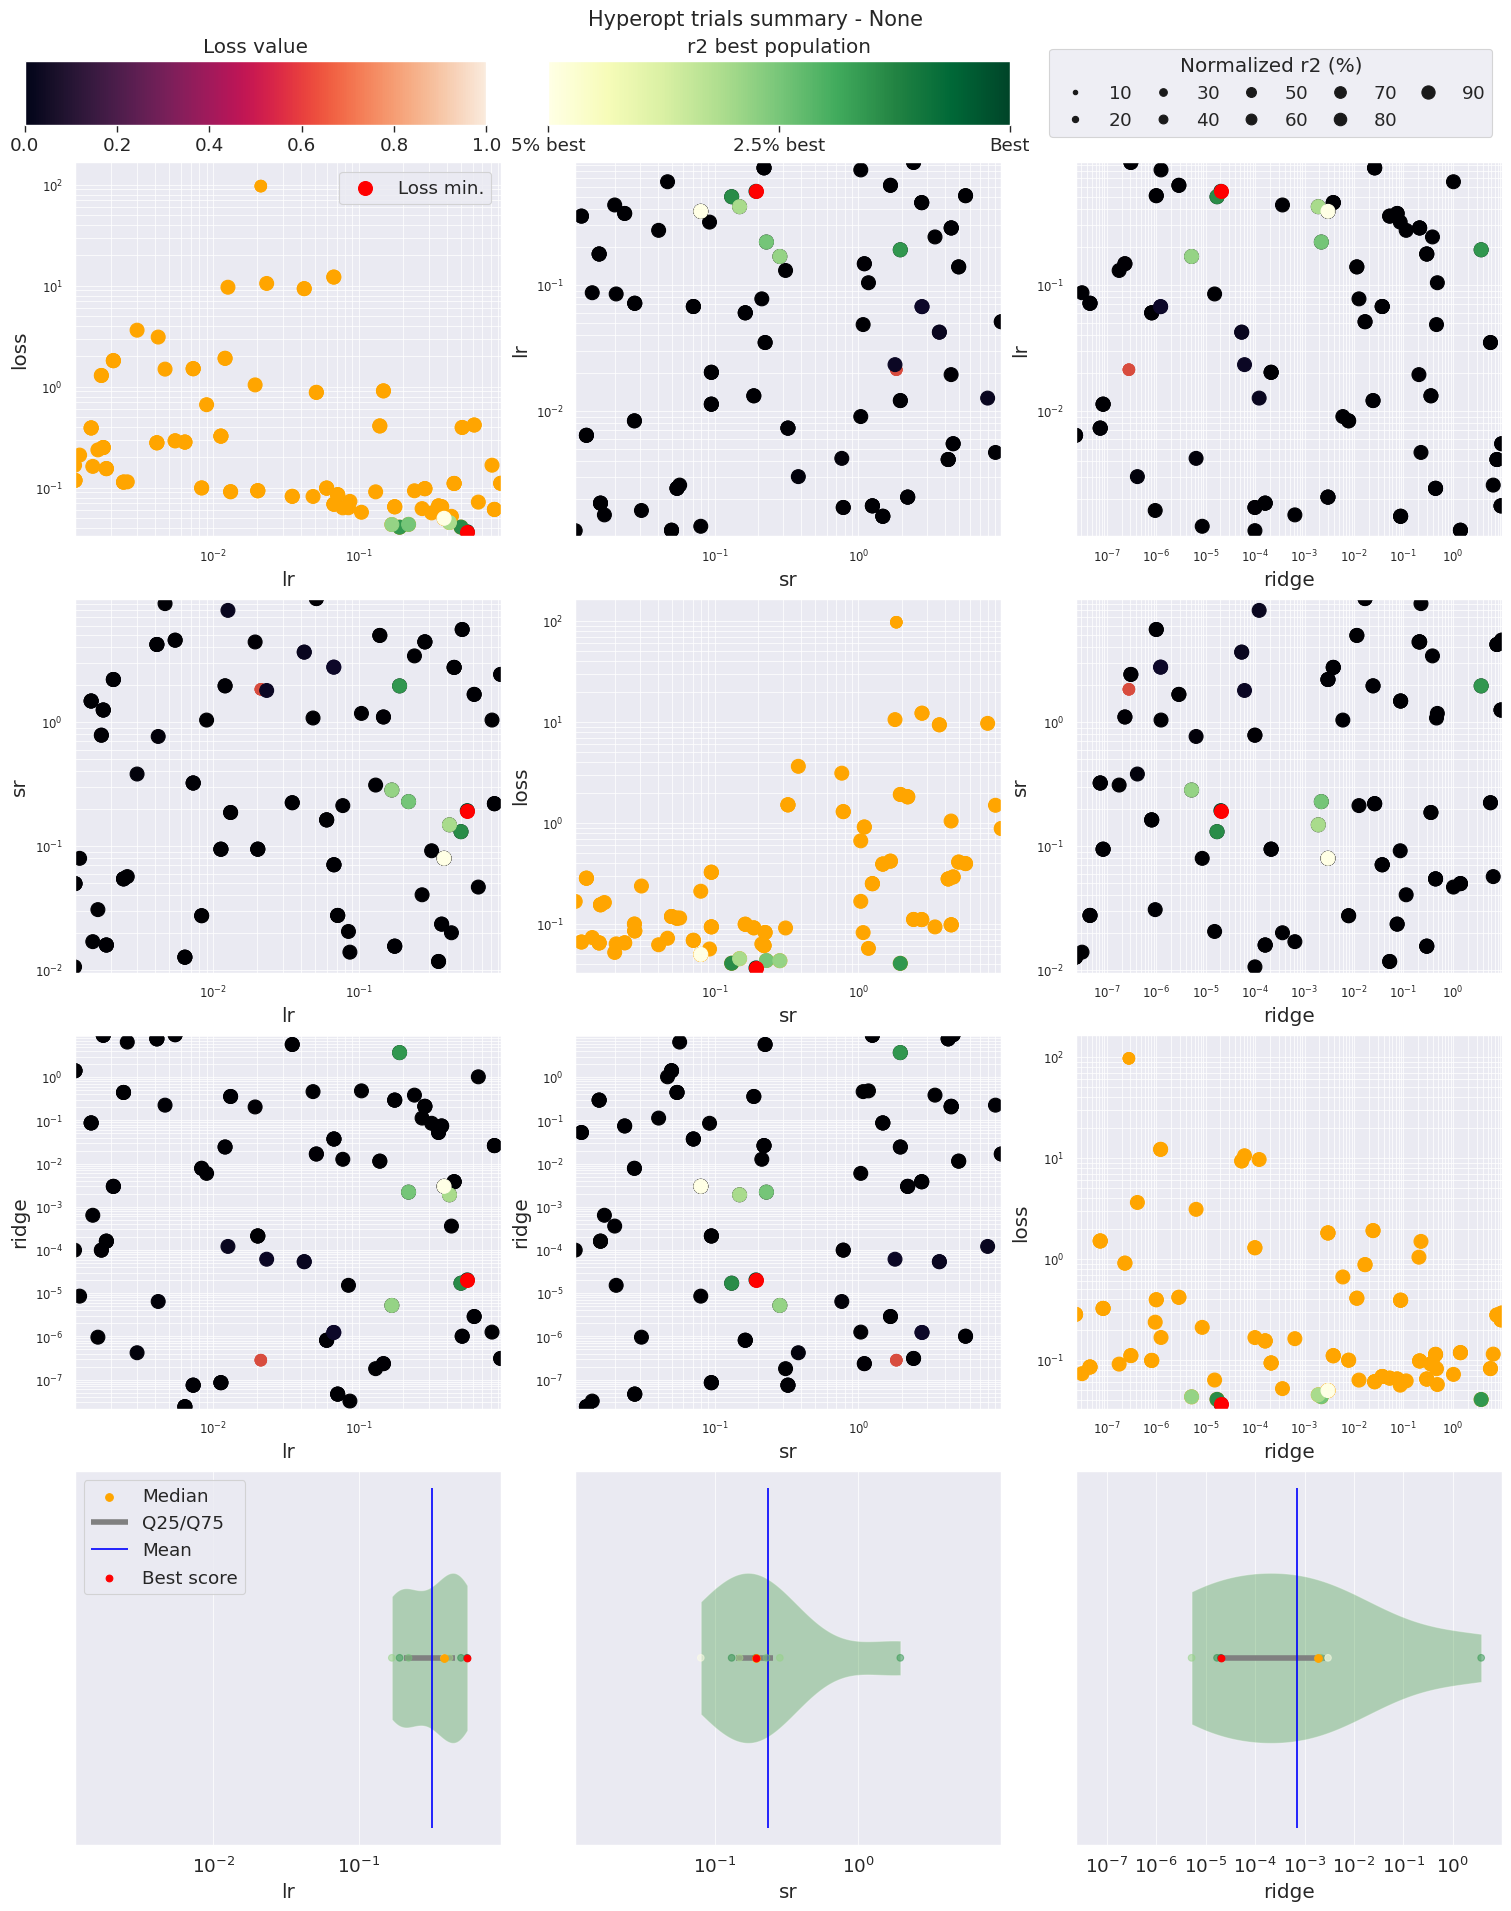

In [16]:
from reservoirpy.hyper import plot_hyperopt_report
fig = plot_hyperopt_report(hyperopt_config["exp"], ("lr", "sr", "ridge"), metric="r2")

## Sine wave ##

In [11]:
X = np.sin(np.linspace(0, 6*np.pi, 100)).reshape(-1,1)

### Normal sine wave ###

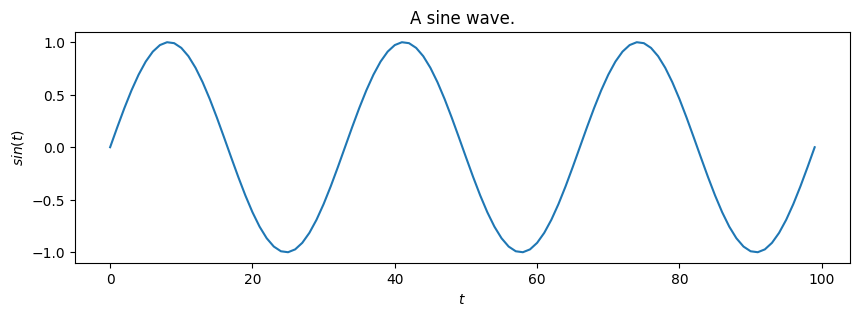

In [12]:
plt.figure(figsize=(10, 3))
plt.title("A sine wave.")
plt.ylabel("$sin(t)$")
plt.xlabel("$t$")
plt.plot(X)
plt.show()
X_train = X[:50]
Y_train = X[1:51]


In [13]:
from reservoirpy.nodes import Reservoir, Ridge

reservoir = Reservoir(100, lr=0.5, sr=0.9)
readout = Ridge(ridge=1e-7)

esn_model = reservoir >> readout

### Train ESN ###

In [14]:
esn_model = esn_model.fit(X_train, Y_train, warmup=10)
print(reservoir.is_initialized, readout.is_initialized, readout.fitted)

Running Model-1:   0%|          | 0/1 [00:00<?, ?it/s]

Running Model-1:   0%|          | 0/1 [00:00<?, ?it/s]

Running Model-1: 50it [00:00, 6385.39it/s]            


Running Model-1: 100%|██████████| 1/1 [00:00<00:00, 79.27it/s]

Fitting node Ridge-2...


True True True


### Run ESN ###

Running Model-1:   0%|          | 0/1 [00:00<?, ?it/s]

Running Model-1: 50it [00:00, 7794.94it/s]            

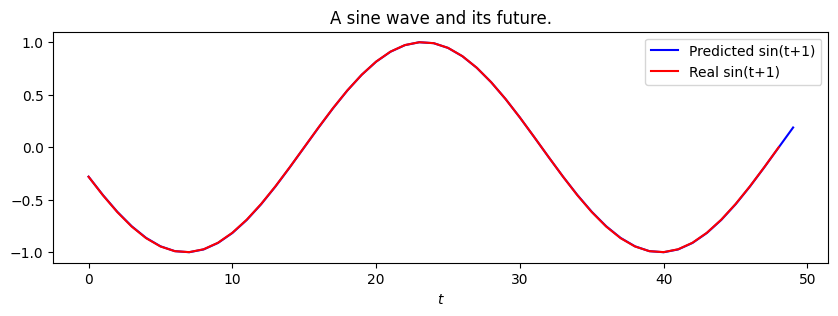

In [15]:
Y_pred = esn_model.run(X[50:])

plt.figure(figsize=(10, 3))
plt.title("A sine wave and its future.")
plt.xlabel("$t$")
plt.plot(Y_pred, label="Predicted sin(t+1)", color="blue")
plt.plot(X[51:], label="Real sin(t+1)", color="red")
plt.legend()
plt.show()
